In [1]:
import sys
sys.path.append('..')
# set environment variable CUDA_LAUNCH_BLOCKING=1
# to debug cuda errors
import os
from data.tile_stitcher import stitch_predictions


In [2]:
ckpt = '2502/goPro2017dehazing-indi-l1/27'
# ckpt = '2502/goPro2017dehazing-indi-l1/36'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'
num_steps_normalization = 10_000
ckpt_time_predictor = None #'2502/Hagen-UnetClassifier-l2/8' #'2502/Hagen-UnetClassifier-l2/3'#None #'2502/Hagen-UnetClassifier-l2/0'
time_predictor = None
# mixing_t_ood = 0.2
mmse_count = 1
eval_datasplit_type = 'test'
# how many images are we considering for evaluation
limit_count = 100

num_timesteps = 1
enable_real_input = False
infer_time = False
use_aggregated_inferred_time = False
use_hardcoded_time_for_inference = None


ckpt = ckpt.strip('/').strip(' ')
ckpt

'2502/goPro2017dehazing-indi-l1/27'

In [3]:
if use_aggregated_inferred_time:
    assert ckpt_time_predictor is not None, 'Time predictor is required for aggregated time inference'
    assert use_hardcoded_time_for_inference is use_hardcoded_time_for_inference, 'Hardcoded time inference is not supported with aggregated time inference'
    assert infer_time is True, 'Time inference must be enabled for aggregated time inference'


if infer_time:
    assert ckpt_time_predictor is not None, 'Time predictor is required for time inference'

if use_hardcoded_time_for_inference is not None:
    assert not infer_time, 'Time inference must be disabled for hardcoded time inference'


In [4]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        # best_files = [f for f in list_of_files if 'best_gen_' in f]
        # assert len(best_files) == 1,f'{best_files}'
        # best_file = best_files[0]  
        fname = latest_file
        return os.path.join(ckpt_dir,fname)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train", "distributed"]
    output = {}
    for k in keys:
        if k in opt:
            output[k] = opt[k]['value']
    return output

In [5]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os
import torch

if ckpt_time_predictor is not None:
    time_pred_ckpt_fpath = os.path.join(training_rootdir, ckpt_time_predictor)

    time_pred_opt = load_config(time_pred_ckpt_fpath)
    time_pred_model_opt = time_pred_opt['model']
    time_predictor = TimePredictor(
        in_channel=time_pred_model_opt['unet']['in_channel'],
        out_channel=time_pred_model_opt['unet']['out_channel'],
        norm_groups=time_pred_model_opt['unet']['norm_groups'],
        inner_channel=time_pred_model_opt['unet']['inner_channel'],
        channel_mults=time_pred_model_opt['unet']['channel_multiplier'],
        attn_res=time_pred_model_opt['unet']['attn_res'],
        res_blocks=time_pred_model_opt['unet']['res_blocks'],
        dropout=time_pred_model_opt['unet']['dropout'],
        image_size=time_pred_opt['datasets']['patch_size'],
        )
    
    time_predictor = time_predictor.cuda()
    time_predictor.load_state_dict(torch.load(os.path.join(time_pred_ckpt_fpath,'best_time_predictor.pth')), strict=True)
    time_predictor.eval()
    print('Loaded time predictor from', time_pred_ckpt_fpath)


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
# opt['path']['resume_state'] = os.path.join(os.path.dirname(opt['path']['resume_state']),'I110000_E1375')
print(opt['path']['resume_state'])

opt['model']['beta_schedule']['val']['n_timestep'] = num_timesteps
if opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('val_jrc_hela','test_jrc_hela')

elif opt['datasets']['train']['name'] == 'hagen':
    opt['datasets']['val']['datapath'] = {
    'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
    'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
    }
elif opt['datasets']['train']['name'] in ['HT_LIF24','HT_LIF']:
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val','/test')


/group/jug/ashesh/training/diffsplit/2502/goPro2017dehazing-indi-l1/27/checkpoint/I890000_E1878


In [7]:
# opt['datasets']['patch_size'] = (720, 1280)
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

if enable_real_input:
    opt['datasets']['train']['real_input_fraction'] = 1.0
    opt['datasets']['val']['real_input_fraction'] = 1.0

opt['datasets']['normalize_channels'] = False

if limit_count is not None:
    opt['datasets']['val']['limit_count'] = limit_count
    opt['datasets']['train']['limit_count'] = limit_count

In [8]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=True, eval_datasplit_type='test')

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

Loading train data
---------------------------------------------------
Loading limited number of images :100!!
---------------------------------------------------


  5%|▌         | 99/1893 [00:09<02:56, 10.19it/s]


Computing mean and std for normalization
[RestorationDataset] Data: 100x2x(3, 720, 1280) Patch:(512, 512) Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False
Loading test data
---------------------------------------------------
Loading limited number of images :100!!
---------------------------------------------------


  9%|▉         | 99/1111 [00:10<01:47,  9.38it/s]


[TilingDataset] Data: 100x2x(3, 720, 1280) Patch:(512, 512) Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False
[InDI]: Sampling mode: linear_indi, Noise mode: gaussian
Scheduler set to ReduceLROnPlateau with patience:  100

--------------------------------------------------
Number of trainable parameters: 2.44M
--------------------------------------------------



In [9]:
if eval_datasplit_type in ['test','val']:
    dset = val_set
elif eval_datasplit_type == 'train':
    dset = train_set

In [10]:
len(dset._data_dict[0])

100

In [11]:
dset[0]['input'].shape, dset[0]['target'].shape

((3, 512, 512), (3, 512, 512))

In [12]:
from split import get_xt_normalizer_restoration
dset.set_random_patching(True)
xt_normalizer= get_xt_normalizer_restoration(dset, opt['datasets']['train'], dummy=False, num_bins=100, num_steps=num_steps_normalization)
dset.set_random_patching(False)

Random patching set to True


  0%|          | 0/10000 [00:00<?, ?it/s]

10008/10000 patches processed:   0%|          | 12/10000 [04:57<68:44:59, 24.78s/it]

Random patching set to False


True

In [13]:
xt_normalizer.data_mean, xt_normalizer.data_std

(tensor([110.5868, 110.6692, 110.6876, 110.5278, 110.5061, 110.6048, 110.8769,
         110.4567, 110.7552, 110.6048, 110.7436, 110.4150, 110.3538, 111.1864,
         110.6878, 110.2705, 110.5919, 110.9655, 110.6752, 110.2729, 110.6236,
         110.3445, 110.8372, 110.5467, 110.4218, 110.5055, 110.5354, 110.6444,
         110.5660, 110.7295, 111.0486, 110.4033, 110.6535, 110.6761, 110.5741,
         110.4919, 110.4259, 110.6644, 110.8551, 110.3927, 110.2966, 110.4779,
         110.2982, 110.6153, 110.2518, 110.3435, 110.8740, 110.5545, 110.5972,
         110.3979, 110.5085, 110.4367, 110.4620, 110.7056, 110.8759, 110.5983,
         110.6581, 110.3921, 110.3531, 110.6862, 110.1488, 110.4376, 110.7454,
         110.6392, 110.2827, 110.4079, 110.4880, 110.6737, 110.4130, 110.7426,
         110.5631, 110.4313, 110.5767, 110.5670, 110.6228, 110.2719, 110.7060,
         110.5963, 110.5022, 110.3548, 110.7195, 110.0809, 110.2733, 110.7329,
         110.2939, 110.6509, 110.6342, 111.0528, 110

In [14]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd



In [15]:
import numpy as np
import random

def get_input_dict(data_dict):
    if opt['datasets']['train']['name'] in ['HT_LIF', 'HT_LIF24']:
        diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
    # elif opt['datasets']['train']['name'] == 'Hagen':
    #     diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
    elif opt['datasets']['train']['name'] in ['Hagen','COSEM_jrc-hela','goPro2017dehazing']:
        if enable_real_input:
            assert 'input' in data_dict and data_dict['input'].std() > 0, 'Input is not available'
            diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
        else:
            diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
            inp = diffusion_data['input']
            diffusion_data['input'] = xt_normalizer1.normalize(inp, torch.Tensor([0.5]*len(inp)), update=False)
        
    return diffusion_data

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# norm_dict = val_set.get_input_target_normalization_dict()
# nimgs = 6
# dloader = torch.utils.data.DataLoader(
#             val_set,
#             batch_size=nimgs,
#             shuffle=True,
#             num_workers=0,
#             pin_memory=True)
# for batch_data in dloader:
#     break

# diffusion_batch_input = get_input_dict(batch_data)

In [17]:
def get_prediction(data_dict, infer_time=True):
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(data_dict, infer_time=infer_time)
    target_unnorm = target_unnorm.transpose(0,2,3,1)
    pred_unnorm = pred_unnorm.transpose(0,2,3,1)
    input_unnorm = input_unnorm.transpose(0,2,3,1)
    return input_unnorm, target_unnorm, pred_unnorm

def get_prediction_raw(data_dict, infer_time=True):
    assert 'input' in data_dict
    assert 'target' in data_dict
    assert len(data_dict['input'].shape) == 4
    assert len(data_dict['target'].shape) == 4
    t_float_start = 0.5
    if time_predictor is not None and infer_time:
        t_float_start = time_predictor(data_dict['input'].cuda())
        
    # NOTE: infer_time=False must be set for recent models.
    prediction = diffusion.netG.inference(data_dict['input'], infer_time=False, t_float_start=t_float_start).detach().cpu().numpy()
    input = data_dict['input'].cpu().numpy()
    target = data_dict['target'].cpu().numpy()

    
    # unnormalize 
    assert len(prediction.shape) == 4
    pred_unnorm = prediction * norm_dict['std_target'] + norm_dict['mean_target']
    target_unnorm = target * norm_dict['std_target'] + norm_dict['mean_target']
    input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']


    if opt['datasets']['train']['name'] == 'cifar10':
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8)
        target_unnorm = target_unnorm.astype(np.uint8)
        input_unnorm = input_unnorm.astype(np.uint16)

    return input_unnorm, target_unnorm, pred_unnorm

In [18]:
diffusion.set_new_noise_schedule(opt['model']['beta_schedule']['val'], schedule_phase='val')


In [19]:
import seaborn as sns
# show_hist = False
# if show_hist:
#     ncols = predictions.shape[-1]
#     _,ax = plt.subplots(figsize=(3*ncols,3),ncols=ncols)
#     for ch_idx in range(ncols):
#         sns.histplot(targets[:,...,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
#         sns.histplot(predictions[:,-1,...,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
#     plt.legend()
#     plt.tight_layout()

## Quantitative Evaluation using the classifier.
Here, we also inspect the effect of MMSE count.

In [20]:

# if time_predictor is not None:
#     t_pred1 = []
#     t_pred2 = []
#     with torch.no_grad():
#         for i in tqdm(range(len(val_set))):
#             data = val_set[i]
#             inp_indi1 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
#             inp_indi2 = data['target'][:1]*mixing_t_ood + data['target'][1:2]*(1-mixing_t_ood)
#             inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
#             inp_indi2 = torch.Tensor(inp_indi2[None]).cuda()
#             # we can use mixing_t_ood for the normalization, because if it is real image, then we anyway have to normalize it separately.
#             norm_inp1 = xt_normalizer1.normalize(inp_indi1.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi1)).cuda(), update=False)
#             norm_inp2 = xt_normalizer2.normalize(inp_indi2.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi2)).cuda(), update=False)
            
#             # time predictor notion of time is 1 - t, This formulation ensures that we have the time corresponding to indi1.
#             t1 = 1 - time_predictor(norm_inp1)
#             t2 = 1 - time_predictor(norm_inp2)
#             t_pred1.append(t1.item())
#             t_pred2.append(t2.item())

#     t_pred1_aggregated = np.mean(t_pred1) 
#     t_pred2_aggregated = np.mean(t_pred2)
#     print(t_pred1_aggregated, t_pred2_aggregated)
# else:
#     t_pred1_aggregated = None
#     t_pred2_aggregated = None

In [21]:
len(val_set)

800

In [22]:
import cv2
indi_model = diffusion.netG
indi_model.eval()
psnr_vals = []
data = val_set[20]
t_vals = list(np.arange(0.6, 1.1, 0.04))
for t in t_vals:
    with torch.no_grad():
        inp_indi1 = torch.Tensor(data['input'][None]).cuda()
        t_clipped = np.clip(t, 0.0, 1.0)
        norm_inp1 = xt_normalizer.normalize(inp_indi1.cuda(), torch.Tensor([t_clipped]*len(inp_indi1)).cuda(), update=False)
        pred = indi_model.inference(norm_inp1, num_timesteps=1, t_float_start=t)

    mean_val = xt_normalizer.data_mean[-1]
    std_val = xt_normalizer.data_std[-1]
    pred_unnorm = pred.cpu().numpy() * std_val.cpu().numpy() + mean_val.cpu().numpy()
    pred_unnorm[pred_unnorm<0] = 0
    pred_unnorm[pred_unnorm>255] = 255
    pred_unnorm = pred_unnorm.astype(np.uint8)[0].transpose(1,2,0)

    psnr_vals.append(cv2.PSNR(data['target'].transpose(1,2,0), pred_unnorm.astype(np.float32)))

print(' '.join([f'{round(t_tmp,2):.2f}' for t_tmp in t_vals]))
print(' '.join([f'{x:.1f}' for x in psnr_vals]))

0.60 0.64 0.68 0.72 0.76 0.80 0.84 0.88 0.92 0.96 1.00 1.04 1.08
24.6 24.7 24.8 24.9 25.2 25.5 25.8 26.1 26.3 26.4 26.3 26.1 26.0


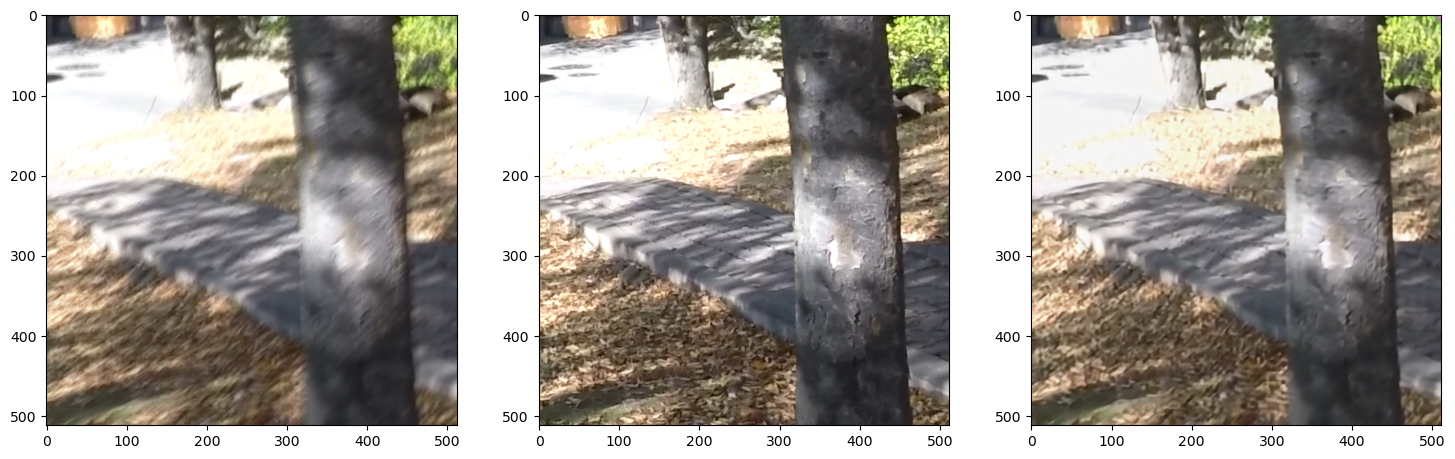

In [23]:
_,ax = plt.subplots(figsize=(18,6),ncols=3)
ax[0].imshow(inp_indi1.cpu().numpy()[0].transpose(1,2,0).astype(np.uint8))
ax[1].imshow(data['target'].transpose(1,2,0).astype(np.uint8))
ax[2].imshow(pred_unnorm.astype(np.uint8))

In [24]:
import cv2
indi_model = diffusion.netG
indi_model.eval()
psnr_vals_dset = []
actual_predictions = []
actual_predictions_bestt = []

actual_predictions_t = 1.0

# data = val_set[20]
t_vals = list(np.arange(0.72, 1.1, 0.04))
t_vals = [round(x,2) for x in t_vals]
assert actual_predictions_t in t_vals, 'Actual prediction time is not in the list of t_vals'

val_dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=4,
            shuffle=False,
            num_workers=4,
            pin_memory=True)

for data in tqdm(val_dloader):
    psnr_vals  = []
    predictions_batch = []
    for t in t_vals:
        with torch.no_grad():
            mmse_pred = 0 
            inp_indi1 = torch.Tensor(data['input']).cuda()
            t_clipped = np.clip(t, 0.0, 1.0)
            norm_inp1 = xt_normalizer.normalize(inp_indi1.cuda(), torch.Tensor([t_clipped]*len(inp_indi1)).cuda(), update=False)
            for _ in range(mmse_count):
                # continuous=True is a hack. otherwise, we just get one entry in the batch
                pred = indi_model.inference(norm_inp1, num_timesteps=1, t_float_start=t, continuous=True)
                # just take the last step for all elements in the batch
                pred = pred[-len(norm_inp1):]
                mmse_pred += pred
            pred = mmse_pred / mmse_count

        mean_val = xt_normalizer.data_mean[0]
        std_val = xt_normalizer.data_std[0]
        pred_unnorm = pred.cpu().numpy() * std_val.cpu().numpy() + mean_val.cpu().numpy()
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8).transpose(0,2,3,1)
        if t == actual_predictions_t:
            actual_predictions.append(pred_unnorm)
        
        predictions_batch.append(pred_unnorm)
        tar_batch = data['target'].cpu().numpy().transpose(0,2,3,1)
        pred_batch = pred_unnorm.astype(np.float32)
        psnr_vals.append(np.array([cv2.PSNR(tar_batch[i], pred_batch[i]) for i in range(len(tar_batch))]))
    idx = np.array(psnr_vals).argmax(axis=0)
    best_prediction = np.stack(predictions_batch)[idx, list(range(len(idx)))]
    actual_predictions_bestt.append(best_prediction)
    psnr_vals_dset.append(np.array(psnr_vals).T)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [02:36<00:00,  1.27it/s]


In [25]:
psnr_data = np.concatenate(psnr_vals_dset, axis=0)
print(psnr_data.mean(axis=0))
psnr_data.shape


[24.7048819  24.95145569 25.35125958 25.81876721 26.33180555 26.75969922
 26.92379594 26.95617249 26.91418141 26.83336496]


(800, 10)

In [26]:
idx = t_vals.index(actual_predictions_t)
assert len(t_vals) == psnr_data.shape[1]
print('Best t PSNR', np.max(psnr_data, axis=1).mean())
print('t=1 PSNR',np.mean(psnr_data[:,idx]))

Best t PSNR 27.042720566991846
t=1 PSNR 26.956172493600818


In [27]:
actual_predictions = np.concatenate(actual_predictions, axis=0)
actual_predictions_bestt = np.concatenate(actual_predictions_bestt, axis=0)

In [28]:
actual_predictions = actual_predictions.transpose(0,3,1,2)
actual_predictions_bestt = actual_predictions_bestt.transpose(0,3,1,2)

In [29]:
actual_predictions.shape

(800, 3, 512, 512)

In [34]:
stitched_pred = stitch_predictions(actual_predictions, val_set.tile_manager)
stitched_pred_bestt = stitch_predictions(actual_predictions_bestt, val_set.tile_manager)
# stitched_pred = stitched_pred.transpose(0,3,1,2)

[100, 720, 1280, 3]
[100, 720, 1280, 3]


In [31]:
tar = np.concatenate([x[None] for x in val_set._data_dict[0]])
tar = tar.transpose(0,2,3,1)

inp = np.concatenate([x[None] for x in val_set._data_dict[1]])
inp = inp.transpose(0,2,3,1)
print(stitched_pred.shape, tar.shape, inp.shape)

(100, 720, 1280, 3) (100, 720, 1280, 3) (100, 720, 1280, 3)


44


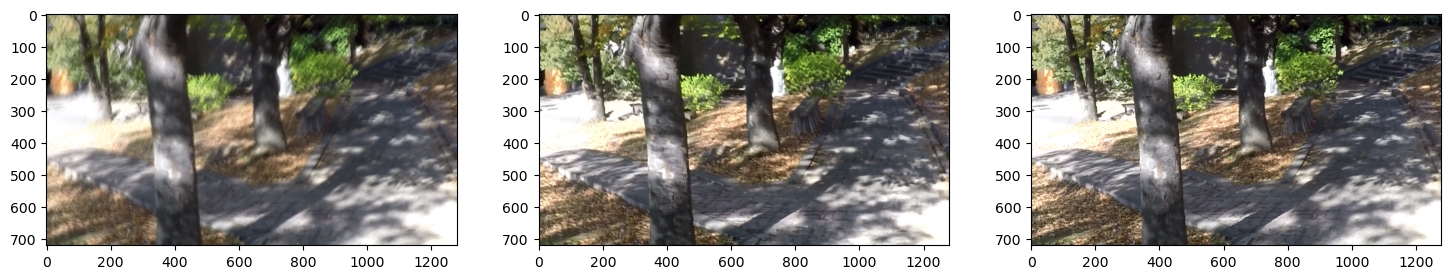

In [32]:
_,ax = plt.subplots(figsize=(18,6),ncols=3)
idx = np.random.randint(0,len(stitched_pred))
print(idx)
ax[0].imshow(inp[idx])
ax[1].imshow(stitched_pred[idx])
ax[2].imshow(tar[idx])